In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy
import seaborn as sns

In [9]:
df=pd.read_csv('SPXData.csv')                     
date=np.array(df.Dates)
byearlist=[i for i in range(1980, 2020)]    # Lists to store the years for plotting yearly returns later
eyearlist=[i for i in range(1981, 2021)]    #The code below extracts the indexes for the beginning dates of the financial yeqrs
num=-1
fl=0
fl2=0
bdatelist=[]                            
bnlist=[]
edatelist=[]
enlist=[]                                     
for begyear, endyear in zip(byearlist, eyearlist):
    fl=0
    fl2=0
    num=-1
    for d in date:
        num+=1
        year=int(d[-4:])
        month=int(d[3:5])
        if (year==begyear and month==1) and (fl==0) :
            n=num
            bdatelist.append(date[num])
            bnlist.append(n)
            fl=1
        if ((endyear!=2020 and (year==endyear and month==1)) and (fl2==0)):
            n2=num
            edatelist.append(date[num-1])
            enlist.append(n2)
            fl2=1
        if(endyear==2020):
            n2=10063
            edatelist.append(date[n2])
            enlist.append(n2)
            break
bdatelist.append(date[9837])
bnlist.append(9837)

In [10]:
dma50=np.array([np.nan for i in range(50)])         #50 Day Moving Average 
su=0
cp=np.array(df['Close Price'])
for i in range(len(cp)):
    if(i<=49):
        su+=cp[i]
        if(i==49):
            dma50=np.append(dma50, su/50)
    else:
        j=i-50
        su-=cp[j]
        su+=cp[i]
        dma50=np.append(dma50, su/50)

In [11]:
dma10=np.array([np.nan for i in range(10)])        #10 Day Moving Average
su=0
for i in range(len(cp)):
    if(i<=9):
        su+=cp[i]
        if(i==9):
            dma10=np.append(dma10, su/10)
    else:
        j=i-10
        su-=cp[j]
        su+=cp[i]
        dma10=np.append(dma10, su/10)

In [14]:
fl=0                    #variable to keep track of whether a long position is held or not
sh=0                    #variable to keep track of whether a short position is held or not
spl=[]                  #list to store selling prices (when closing a long position)
bpl=[]                  #List to store buying prices  (when closing a short position)
splshort=[]             #list to store selling prices (when opening a short position) 
bplshort=[]             #list to store buying prices (when closing a short position)
Max=0                   #variable to store the local maxima from the day long position is held
Min=1000000             #variable to store the local minima from the day short position is held
longbuydate=[]          #list to store the dates on which long position was opened
longselldate=[]         #list to store the dates on which long position was closed
shortselldate=[]        #list to store the dates on which short position was opened
shortbuydate=[]         #list to store the dates on which short position was closed 
timeseries=[]           #list to store value of the portfolio for plotting 
retalgolist=[]          #list to store the yearly returns generated by the algorithm
retmarklist=[]          #list to store the yearly returns generated by the market
print("The prices hovered around 110 $ at the beginning of 1980.")   
ini=float(input("Input the initial amount to be invested- "))
portfolio=ini           #assigning the value of the portfolio to be the initial investment
c=1

The prices hovered around 110 $ at the beginning of 1980.
Input the initial amount to be invested- 100


In [15]:
for n,n2 in zip(bnlist,enlist):
    if(c==1):
        c+=1
        INI=ini
    else:
        INI=timeseries[-1]
    for i in range(n,n2):
        if(math.isnan(dma50[i])):
           timeseries.append(portfolio)
           continue
        if(fl==1 ):
            z=portfolio+cp[i]
            if(sh==1):
                z-=cp[i]
                if(cp[i]<Min):
                    Min=cp[i]               #updating the value of minima if there's an open short position
            timeseries.append(z)
            if(cp[i]>Max):                  
                Max=cp[i]                   #updating the value of maxima if there's an open long position
        if(fl==0 and sh==0):
            timeseries.append(portfolio)
        if(fl==0 and sh==1):                   
            if(cp[i]<Min):                  #updating the value of minima if there's an open short position
                Min=cp[i]
            timeseries.append(portfolio-cp[i])
        if(fl==0 and (dma10[i]>dma50[i]) and dma10[i-1]<=dma50[i-1]): 
            bp=cp[i+1]
            if(bp<=portfolio):              #opening a long position IFF adequate amount is present in the portfolio
                fl=1
                bpl.append(bp)
                portfolio-=bp
                longbuydate.append(date[i])
        if(sh==1 and (cp[i]>cp[i-1]*1.03 or cp[i]>1.1*Min)): 
            Min=100000                      #closing a short position IFF closing price of a day is exceeds the previous day clo-
            portfolio-=cp[i+1]              #sing price by more than 300 bps. Another closing condition is triggered if the  
            bplshort.append(cp[i+1])        #closing price exceeds the local minima by more than 1000 bps.
            shortbuydate.append(date[i])
            sh=0
        if(sh==0 and (dma50[i]>dma10[i] and dma10[i-1]>=dma50[i-1])):
            sp=cp[i+1]                      #opening a short position
            portfolio+=sp 
            splshort.append(sp)
            shortselldate.append(date[i])
            Min=cp[i+1]
            sh=1
        if(fl==1 and (cp[i]<Max*0.9 or cp[i]<0.93*cp[i-1])):
            Max=0                          #closing a long position IFF closing price dips by more than 1000 basis points from 
            sp=cp[i+1]                     #the local maxima. Another closing condition is triggered if there's a difference of 
            spl.append(sp)                 #more than 700 bps between closing price of any two days
            longselldate.append(date[i])
            portfolio+=sp
            fl=0
    p=portfolio                            
    if(fl==1):                             #in case long position is held, portfolio value (including unrealised gains)
        p+=cp[n2]
    if(sh==1):                             #in case short position is held, portfolio value
        p-=cp[n2]
    mreturns=((cp[n2]/cp[n])-1)*100
    algoreturns=((p/INI) - 1)*100
    retalgolist.append(algoreturns)
    retmarklist.append(mreturns)

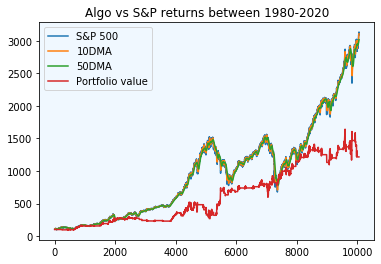

In [16]:
plt.rcParams['axes.facecolor'] = 'aliceblue'                  #plotting the portfolio vs the market
plt.plot(cp)
plt.plot(dma10)
plt.plot(dma50)
plt.plot(timeseries)
plt.title("Algo vs S&P returns between 1980-2020")
plt.legend(['S&P 500', '10DMA', '50DMA', 'Portfolio value'])
plt.show()

Market returns= 2862.97%
Algo returns= 1116.42%

The algo beat the market 14 times over the 40 years it was backtested for.
Win/Loss Ratio= 0.59


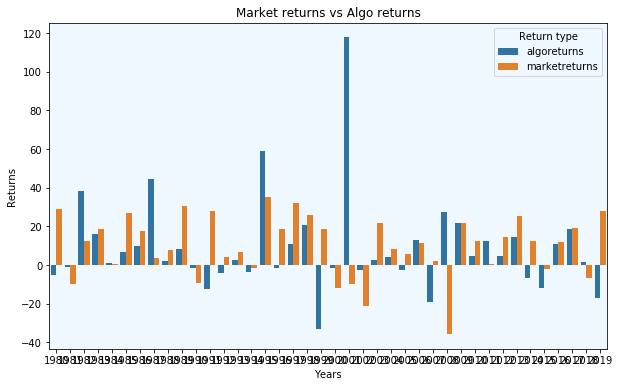

In [17]:
w=0                             #win/loss Ratio
l=0
for s, b in zip(spl, bpl):
       if(s-b>=0):
           w+=1
       else:
           l+=1
for s, b in zip(splshort, bplshort):
       if(s-b>=0):
           w+=1
       else:
           l+=1
mreturns=(cp[-1]/cp[0]-1)*100               #Market returns (1980-2020)
algoreturns=(portfolio/ini-1)*100           #Algo returns (1980-2020)
print("Market returns= {:.2f}%\nAlgo returns= {:.2f}%\n".format(mreturns, algoreturns))
correlation, pvalue=scipy.stats.pearsonr(retalgolist, retmarklist)     #correlation between the algo and market returns
#print(correlation)
x=[]
for i in range(1980,2020):
    x.append(i)
    x.append(i)
allretlist=[]
rettypelis=[]
c=0
for a,m in zip(retalgolist, retmarklist):
    allretlist.append(a)
    rettypelis.append("algoreturns")
    allretlist.append(m)
    rettypelis.append("marketreturns")
    if(a>m):
        c+=1
print("The algo beat the market {} times over the 40 years it was backtested for.".format(c))
#print(timeseries[-1], portfolio, cp[-1])
data={'Years':x, 'Returns':allretlist, 'Return type':rettypelis}
df=pd.DataFrame(data, index=x)
plt.figure(figsize=(10, 6))
ax=sns.barplot(x=x, y='Returns', hue='Return type', data=df)
ax.set(xlabel='Years')
plt.title('Market returns vs Algo returns')
print("Win/Loss Ratio= {:.2f}".format(w/l))
plt.show()